# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import sklearn

/Users/laiyihui/anaconda3/envs/stat_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read dataset

In [2]:
df = pd.read_csv('Combined_Flights_2018.csv', usecols=['Origin', 'Dest', 'Cancelled', 'CRSDepTime', 'DepDelay', 'CRSElapsedTime', 'Distance', 'Month', 'DayofMonth', 'DayOfWeek', 'IATA_Code_Operating_Airline', 'CRSArrTime', 'ArrDelay', 'ArrivalDelayGroups'])
print(df.head())
print(df.shape)
df = df.dropna()
print(df.shape)

  Origin Dest  Cancelled  CRSDepTime  DepDelay  CRSElapsedTime  Distance  \
0    ABY  ATL      False        1202      -5.0            62.0     145.0   
1    ABY  ATL      False        1202      -5.0            62.0     145.0   
2    ABY  ATL      False        1202      -9.0            62.0     145.0   
3    ABY  ATL      False        1202     -12.0            62.0     145.0   
4    ABY  ATL      False        1400      -5.0            60.0     145.0   

   Month  DayofMonth  DayOfWeek IATA_Code_Operating_Airline  CRSArrTime  \
0      1          23          2                          9E        1304   
1      1          24          3                          9E        1304   
2      1          25          4                          9E        1304   
3      1          26          5                          9E        1304   
4      1          27          6                          9E        1500   

   ArrDelay  ArrivalDelayGroups  
0      -8.0                -1.0  
1      -6.0             

# Data preprocessing

## drop cancelled flights

In [3]:
df_col = df.loc[df['Cancelled'] == False]
print(df_col.shape)
df_col = df_col.drop('Cancelled', axis=1)
print(df_col.shape)
# simplfy column_names
df_col.rename(columns = {'CRSDepTime': 'DepTime', 'CRSElapsedTime': 'ElapsedTime','DayOfWeek': 'DayofWeek', 'IATA_Code_Operating_Airline': 'Airline', 'CRSArrTime': 'ArrTime', 'ArrivalDelayGroups':'ArrGroup'}, inplace = True)
print(df_col.head())

(5585544, 14)
(5585544, 13)
  Origin Dest  DepTime  DepDelay  ElapsedTime  Distance  Month  DayofMonth  \
0    ABY  ATL     1202      -5.0         62.0     145.0      1          23   
1    ABY  ATL     1202      -5.0         62.0     145.0      1          24   
2    ABY  ATL     1202      -9.0         62.0     145.0      1          25   
3    ABY  ATL     1202     -12.0         62.0     145.0      1          26   
4    ABY  ATL     1400      -5.0         60.0     145.0      1          27   

   DayofWeek Airline  ArrTime  ArrDelay  ArrGroup  
0          2      9E     1304      -8.0      -1.0  
1          3      9E     1304      -6.0      -1.0  
2          4      9E     1304      -2.0      -1.0  
3          5      9E     1304     -11.0      -1.0  
4          6      9E     1500      -1.0      -1.0  


## one-hot encoded

In [4]:
origin = pd.get_dummies(df_col['Origin'], prefix='origin')
print(origin.shape)
dest = pd.get_dummies(df_col['Dest'], prefix='dest')
print(dest.shape)
month = pd.get_dummies(df_col['Month'], prefix='month')
print(month.shape)
day_m = pd.get_dummies(df_col['DayofMonth'], prefix='day_m')
print(day_m.shape)
day_w = pd.get_dummies(df_col['DayofWeek'], prefix='day_w')
print(day_w.shape)
airline = pd.get_dummies(df_col['Airline'], prefix='airline')
print(airline.shape)

(5585544, 370)
(5585544, 370)
(5585544, 12)
(5585544, 31)
(5585544, 7)
(5585544, 28)


In [5]:
# drop original columns
df_new = df_col.drop(columns=['Origin', 'Dest', 'Month', 'DayofMonth', 'DayofWeek', 'Airline'])
print(df_new.shape)

# combine dataset together
df_new = pd.concat([df_new, origin], axis=1)
df_new = pd.concat([df_new, dest], axis=1)
df_new = pd.concat([df_new, month], axis=1)
df_new = pd.concat([df_new, day_m], axis=1)
df_new = pd.concat([df_new, day_w], axis=1)
df_new = pd.concat([df_new, airline], axis=1)
print(df_new.shape)

(5585544, 7)
(5585544, 825)


## Numerical data 

In [6]:
# Convert 24h-formatted time to minutes 
def time_to_minutes(time_24h):
    """Convert 24h-formatted time to minutes."""
    return (time_24h // 100) * 60 + (time_24h % 100)

df_new['DepTime'] = df_new['DepTime'].apply(time_to_minutes)
df_new['ArrTime'] = df_new['ArrTime'].apply(time_to_minutes)

##### Notes #####
''' 
ArrGroup is just the sign of ArrDelay (minutes) 
Distance is the distance between airports (miles) 
DepTime is the CRS departure time (HHMM) 

DepTime + DepDelay is the actual departure time (HHMM) 
We can normalize each column individually despite the relation between DepTime and DepDelay, 
since DepTime is going to tell us how busy the airport is at that time of day, and DepDelay is related to the flight itself. 
In other words, we treat them as separate features. 
''' 

# Normalize and standardize columns 
columns_to_normalize = ['DepTime', 'ArrTime', 'DepDelay', 'ArrDelay', 'ElapsedTime', 'Distance']

# Necessary imports 
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Initialize scalers
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

##### Notes #####
'''
The rescaling of data depends on the model we are using. 
Here I apply both MinMaxScaler and StandardScaler to the data, and name the new columns accordingly.
The original columns are dropped at the end. 
'''

for column in columns_to_normalize:
    # Create normalized columns
    # df_new[column + '_normalized'] = minmax_scaler.fit_transform(df_new[[column]])
    
    # Create standardized columns
    # df_new[column + '_standardized'] = standard_scaler.fit_transform(df_new[[column]])
    df_new[column] = standard_scaler.fit_transform(df_new[[column]])
    # Drop the original columns
    # df_new.drop(column, axis=1, inplace=True)


print(df_new[columns_to_normalize].head())

    DepTime   ArrTime  DepDelay  ArrDelay  ElapsedTime  Distance
0 -0.292353 -0.372060 -0.333656 -0.282709    -1.056247 -1.083607
1 -0.292353 -0.372060 -0.333656 -0.240572    -1.056247 -1.083607
2 -0.292353 -0.372060 -0.422146 -0.156299    -1.056247 -1.083607
3 -0.292353 -0.372060 -0.488514 -0.345914    -1.056247 -1.083607
4  0.107107 -0.001236 -0.333656 -0.135230    -1.083639 -1.083607


## Split dataset

In [7]:
from sklearn.model_selection import train_test_split
# for regression
X = df_new.drop(columns=['ArrDelay',  'ArrGroup'])
y = df_new['ArrDelay']
## for classification
# Y = df_new['ArrGroup']

# split train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
# split train - train/validate
X_training, X_val, y_training, y_val = train_test_split(X_train, y_train, test_size=0.11, random_state=42)

print(X_training.shape, X_val.shape, X_test.shape)
print(y_training.shape, y_val.shape, y_test.shape)

(4474020, 823) (552969, 823) (558555, 823)
(4474020,) (552969,) (558555,)


# Data visualization

## histogram - barplot

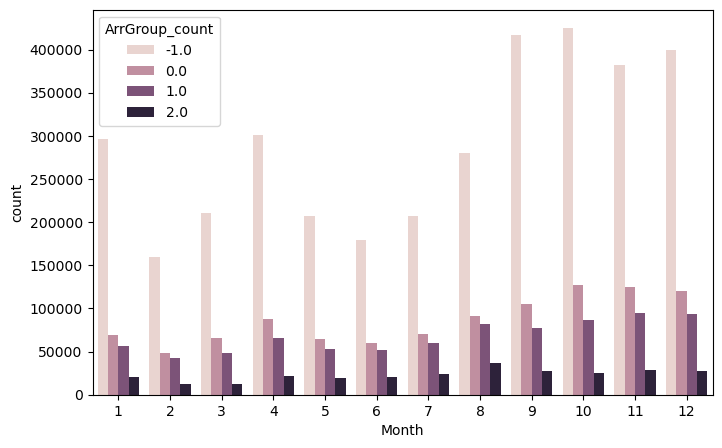

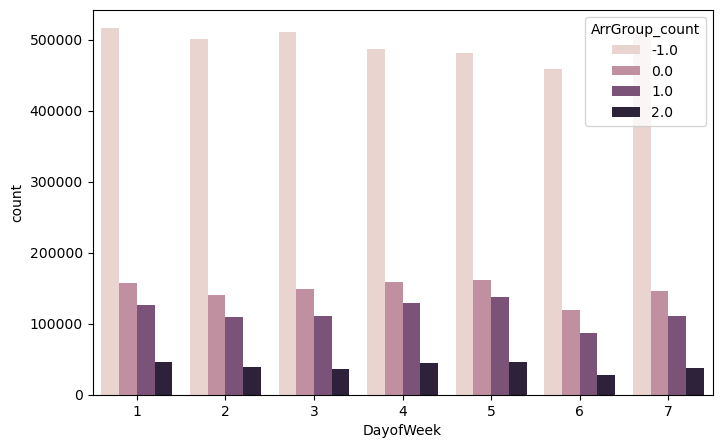

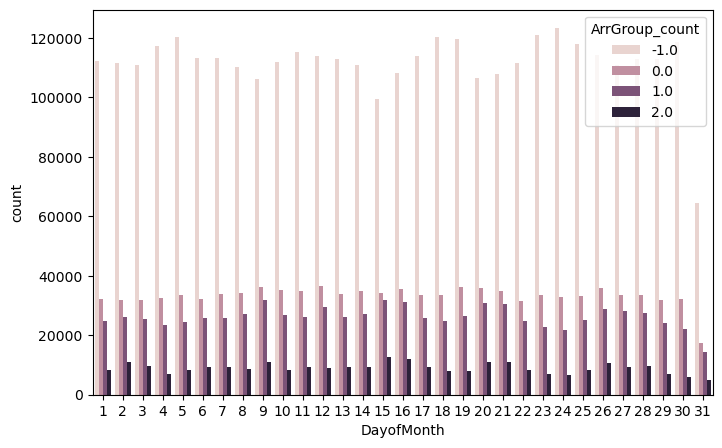

In [15]:
%matplotlib inline
import seaborn as sns

df_col['ArrGroup_count'] =df_col['ArrGroup'].apply(lambda x: (x>4 and 2) or (x>0 and 1) or (x<0 and -1) or x)

# fig = plt.figure(figsize=(8, 5))
# g = sns.violinplot(data=df_col, y='ArrGroup_count', x='Month') # y='ArrDelay'
# g.set_xticks(range(-1, 3))
# # sns.catplot(data=df_col, y='ArrGroup', x='Month')
# fig = plt.figure(figsize=(8, 5))
# sns.violinplot(data=df_col, y='ArrGroup', x='DayofWeek', width=0.5)
# fig = plt.figure(figsize=(8, 5))
# sns.violinplot(data=df_col, y='ArrGroup', x='DayofMonth', width=0.5)
fig = plt.figure(figsize=(8, 5))
g = sns.countplot(data=df_col, hue='ArrGroup_count', x='Month') # y='ArrDelay'

fig = plt.figure(figsize=(8, 5))
g = sns.countplot(data=df_col, hue='ArrGroup_count', x='DayofWeek') # y='ArrDelay'

fig = plt.figure(figsize=(8, 5))
g = sns.countplot(data=df_col, hue='ArrGroup_count', x='DayofMonth') # y='ArrDelay'

<Figure size 800x500 with 0 Axes>

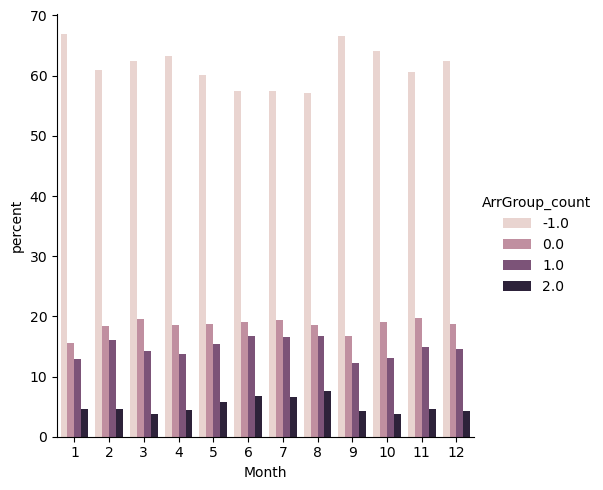

<Figure size 800x500 with 0 Axes>

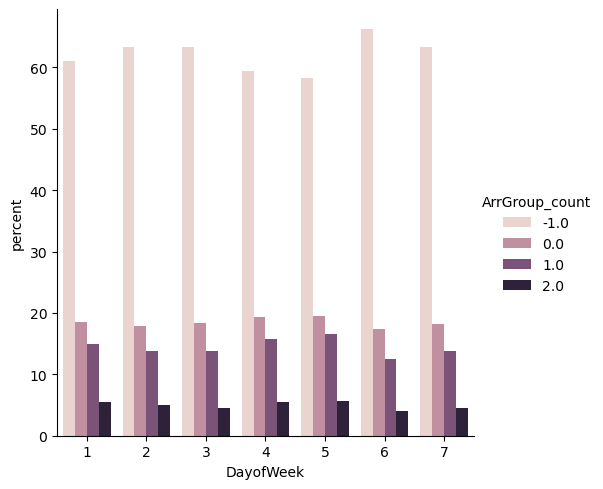

<Figure size 800x500 with 0 Axes>

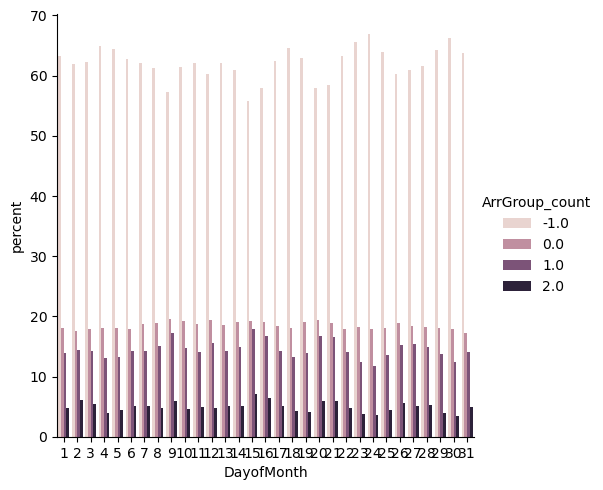

In [16]:
fig = plt.figure(figsize=(8, 5))
x,y = 'Month', 'ArrGroup_count'
(df_col.groupby(x)[y].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))

fig = plt.figure(figsize=(8, 5))
x,y = 'DayofWeek', 'ArrGroup_count'
(df_col.groupby(x)[y].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))

fig = plt.figure(figsize=(8, 5))
x,y = 'DayofMonth', 'ArrGroup_count'
(df_col.groupby(x)[y].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))

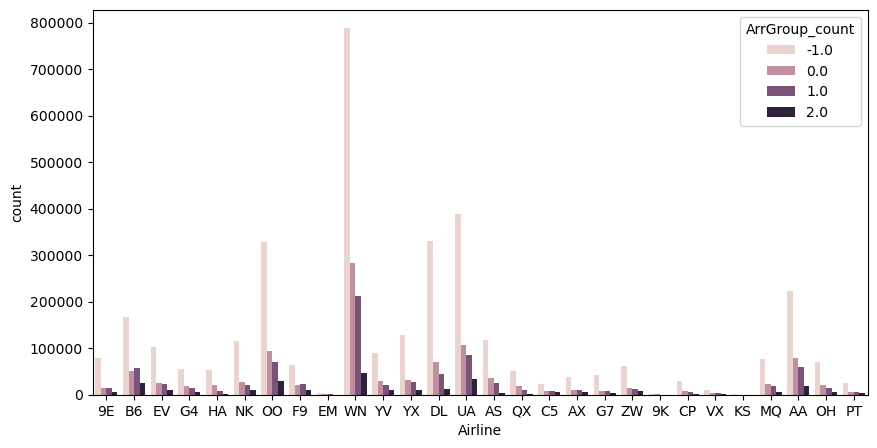

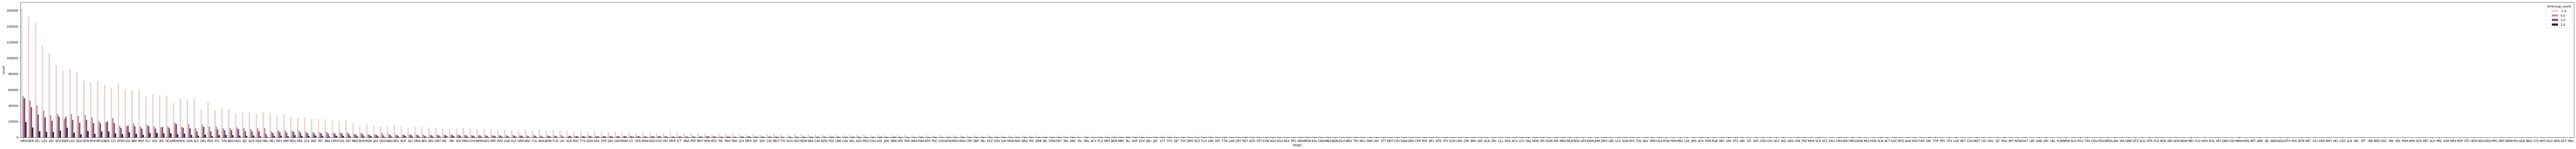

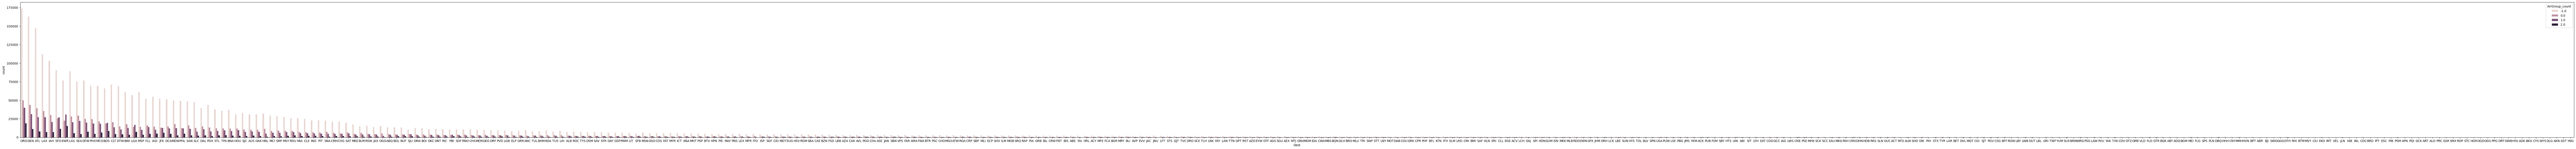

In [24]:
fig = plt.figure(figsize=(10, 5))
g = sns.countplot(data=df_col, hue='ArrGroup_count', x='Airline') # y='ArrDelay'

# fig = plt.figure(figsize=(150, 8))
# df_sorted = df_col.sort_values('Origin')
# g = sns.countplot(data=df_sorted, hue='ArrGroup_count', x='Origin') # y='ArrDelay'

# fig = plt.figure(figsize=(150, 8))
# df_sorted = df_col.sort_values('Dest')
# g = sns.countplot(data=df_sorted, hue='ArrGroup_count', x='Dest') # y='ArrDelay'

fig = plt.figure(figsize=(150, 8))
df_sorted = df_col.sort_values('Origin')
g = sns.countplot(data=df_sorted, hue='ArrGroup_count', x='Origin', order = df_sorted['Origin'].value_counts().index)

fig = plt.figure(figsize=(150, 8))
df_sorted = df_col.sort_values('Dest')
g = sns.countplot(data=df_sorted, hue='ArrGroup_count', x='Dest', order = df_sorted['Dest'].value_counts().index)

# fig = plt.figure(figsize=(10, 5))
# sns.violinplot(data=df_col, y='ArrGroup', x='Airline')

# df_sorted = df_col.sort_values('Origin')
# fig = plt.figure(figsize=(150, 8))
# sns.violinplot(data=df_sorted, y='ArrGroup', x='Origin')

# df_sorted = df_col.sort_values('Dest')
# fig = plt.figure(figsize=(150, 8))
# sns.violinplot(data=df_sorted, y='ArrGroup', x='Dest')

<Figure size 640x480 with 0 Axes>

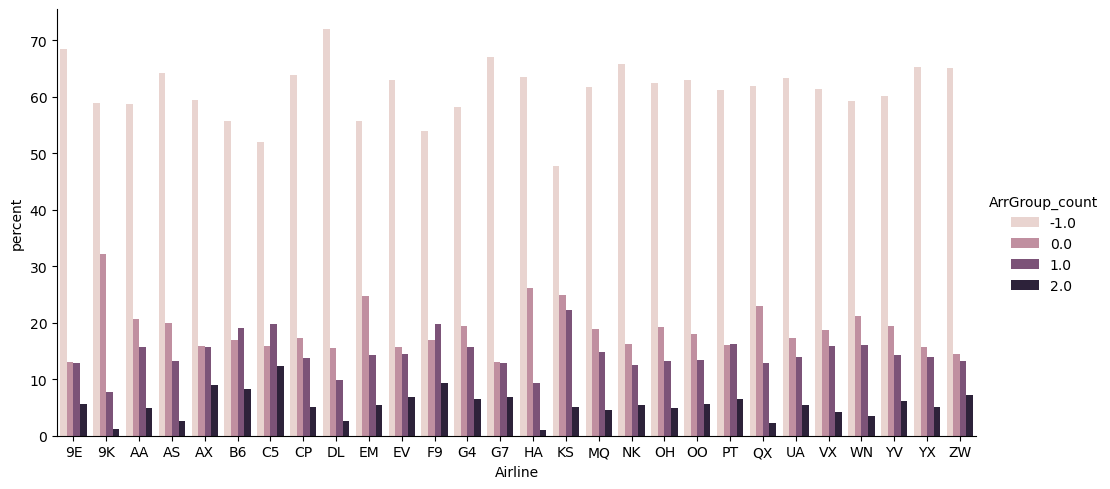

<Figure size 640x480 with 0 Axes>

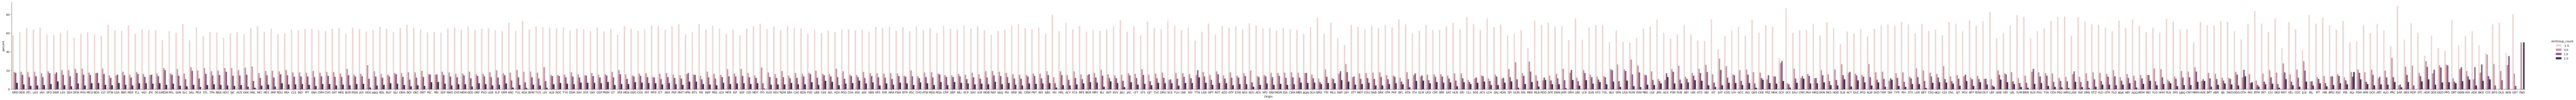

<Figure size 640x480 with 0 Axes>

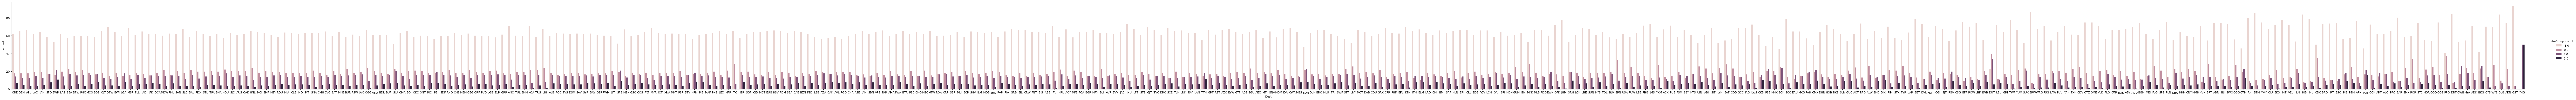

In [23]:
fig = plt.figure()
x,y = 'Airline', 'ArrGroup_count'
(df_col.groupby(x)[y].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar', aspect=2))

fig = plt.figure()
x,y = 'Origin', 'ArrGroup_count'
df_sorted = df_col.sort_values('Origin')
(df_col.groupby(x)[y].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar', order = df_sorted['Origin'].value_counts().index, aspect=25))

fig = plt.figure()
x,y = 'Dest', 'ArrGroup_count'
df_sorted = df_col.sort_values('Dest')
(df_col.groupby(x)[y].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar', order = df_sorted['Dest'].value_counts().index, aspect=25))

## PCA visualization

In [31]:
from sklearn.decomposition import PCA
# plot_train = pd.concat([X_train, y_train], axis=1)
pca = PCA(n_components=5)
components = pca.fit_transform(X_train)
total_var = pca.explained_variance_ratio_.sum() * 100
print(total_var)


49.17230211728415


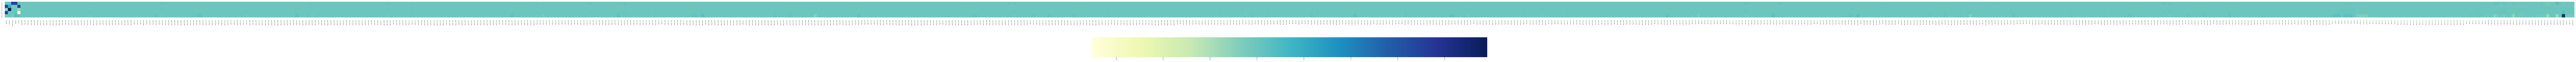

In [33]:
fig = plt.figure(figsize=(150, 8))
sns.set(font_scale = 0.4)
ax = sns.heatmap(pca.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(x) for x in range(1,pca.n_components_+1)],
                 xticklabels=list(X_train.columns),
                 cbar_kws={"orientation": "horizontal"})
ax.set_aspect("equal")
plt.tight_layout()

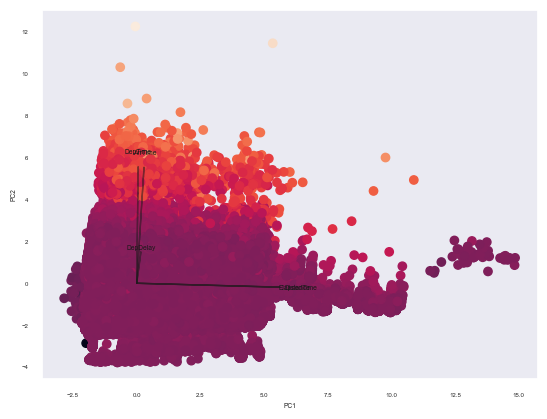

In [39]:
# plt.tricontourf(*components.T, y_train, cmap='terrain', levels=100)
# loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# fig = plt.scatter(x=components[:, 0], y=components[:, 1], c=y_train)
# # for i, feature in enumerate(X_train.columns):
# #     fig.add_annotation(
# #         ax=0, ay=0,
# #         axref="x", ayref="y",
# #         x=loadings[i, 0],
# #         y=loadings[i, 1],
# #         showarrow=True,
# #         arrowsize=2,
# #         arrowhead=2,
# #         xanchor="right",
# #         yanchor="top"
# #     )
# #     fig.add_annotation(
# #         x=loadings[i, 0],
# #         y=loadings[i, 1],
# #         ax=0, ay=0,
# #         xanchor="center",
# #         yanchor="bottom",
# #         text=feature,
# #         yshift=5,
# #     )
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.colorbar()
# plt.show()

def myplot(score,coeff):
    xs = score[:,0]
    ys = score[:,1]
    n = 5

    plt.scatter(xs ,ys, c = y_train)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0]*8, coeff[i,1]*8,color = 'k',alpha = 0.5)
        plt.text(coeff[i,0]* 9, coeff[i,1] * 9, X_train.columns[i], color = 'k', ha = 'center', va = 'center')

fig = plt.figure()
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. 
myplot(components[:,0:2], pca.components_.T) 
plt.show()


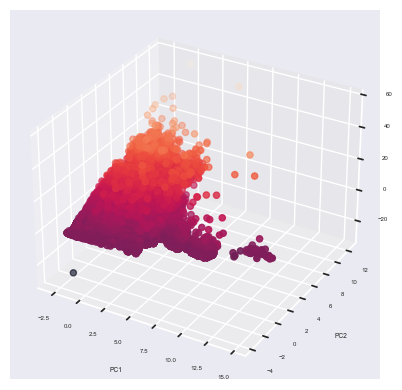

In [40]:
fig = plt.figure()
ax = plt.axes(projection ="3d")
ax.scatter3D(xs=components[:, 0], ys=components[:, 1], zs=components[:, 2], c=y_train)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

In [27]:
print(y_train.max(), y_train.min())

55.40105331859836 -27.292388643430538


# MLP regression model

In [48]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.datasets import load_digits
from tqdm import tqdm

In [42]:
class MLP(nn.Module):
    '''
    Multilayer Perceptron for regression.
    '''
    def __init__(self, width):
        super().__init__() 
        torch.manual_seed(0) #setseed

        layer_list = []
        layer_list.append(nn.Linear(823, pow(2,width))) #expand to 2^width features
        layer_list.append(nn.ReLU())

        width_lay = width
        for i in range(6,width):
            layer_list.append(nn.Linear(pow(2,width_lay), pow(2,width_lay-1)))
            layer_list.append(nn.ReLU())
            width_lay -= 1
        layer_list.append(nn.Linear(64, 1))  # regression output
        self.layers = nn.Sequential(*layer_list)

    def forward(self, x):
        return self.layers(x)

## Define utils functions

In [49]:
def fit_and_evaluate(net, optimizer, loss_func, train, val, n_epochs, batch_size=1):
    '''
    Fits the neural network using the given optimizer, loss function, training set
    Arguments:
        net: the neural network
        optimizer: a optim.Optimizer used for some variant of stochastic gradient descent
        train: a torch.utils.data.Dataset
        test: a torch.utils.data.Dataset
        n_epochs: the number of epochs over which to do gradient descent
        batch_size: the number of samples to use in each batch of gradient descent

    Returns:
        train_epoch_loss, test_epoch_loss: two arrays of length n_epochs+1,
        containing the mean loss at the beginning of training and after each epoch
    '''
    # Prepare data
    train_dl = torch.utils.data.DataLoader(train, batch_size)       
    val_dl = torch.utils.data.DataLoader(val)

    train_losses = []
    val_losses = []

    # Compute the loss on the training and validation sets at the start,
    # being sure not to store gradient information (e.g. with torch.no_grad():)
    net.eval()
    with torch.no_grad():
        train_losses.append(epoch_loss(net, loss_func, train_dl))
        val_losses.append(epoch_loss(net, loss_func, val_dl))
        
    # Train the network for n_epochs, storing the training and validation losses
    # after every epoch. Remember not to store gradient information while calling
    # epoch_loss
    for epoch in tqdm(range(n_epochs)):
        #training
        net.train()
        for iteration, (xb, yb) in enumerate(train_dl):
            train_batch(net, loss_func, xb, yb, opt=optimizer)
        #testing
        net.eval()
        with torch.no_grad():
            train_losses.append(epoch_loss(net, loss_func, train_dl))
            val_losses.append(epoch_loss(net, loss_func, val_dl))

        # save checkpoint!=================================================
        if ((epoch%1) == 0):
            torch.save({
                'epoch': epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': [train_losses, val_losses],
                }, './checkpoint/checkpoint_epoch_%s'%epoch)
        
    return train_losses, val_losses

def train_batch(net, loss_func, xb, yb, opt=None):
    ''' 
    @param net: the neural network
    @param loss_func: the loss function (can be applied to model(xb), yb)
    @param xb: a batch of the training data to input to the model
    @param yb: a batch of the training labels to input to the model
    @param opt: a torch.optimizer.Optimizer used to improve the model.
    '''
    # Zero the gradients
    opt.zero_grad()  
    # Perform forward pass
    yi = net(xb)
    # Compute loss
    loss = loss_func(yi, yb) 
    # Perform backward pass
    loss.backward()
    # Perform optimization
    opt.step()

def torch_datap(feature_col, label): 
    feature_t = torch.tensor(feature_col.values, dtype=torch.float)
    label_t = torch.tensor(label.values, dtype=torch.float)
    datap = torch.utils.data.TensorDataset(feature_t, label_t)
    return datap

def epoch_loss(net, loss_func, data_loader):
    ''' Computes the average loss of the model on the entire dataset
    @param net: The neural network to be evaluated
    @param loss_func: The loss function used to evaluate the neural network
    @param data_loader: The DataLoader which loads minibatches of the dataset
    @return The network's average loss over the dataset.
    '''
    total_examples = 0
    losses = []
    for X, Y in data_loader:
        total_examples += len(X)
        losses.append(loss_func(net(X), Y).item() * len(X)) # Compute total loss for batch

    return torch.tensor(losses).sum() / total_examples

In [53]:
# Prepare dataset 
# print(X_training.iloc[0:10,:].shape, y_training.iloc[0:10].shape)
test_size = 10000
training_p = torch_datap(X_training.iloc[0:test_size,:], y_training.iloc[0:test_size])
valid_p = torch_datap(X_val.iloc[0:test_size,:], y_val.iloc[0:test_size])
# training_p = torch_datap(X_training, y_training)
# valid_p = torch_datap(X_val, y_val)

# Initialize model, optimizer, loss_func
model = MLP(width=10) #change width!===============================================================================
print(model)
optimizer=torch.optim.SGD( model.parameters(), lr=0.005, momentum=0 ) #change lr, momentum, ADAM!==================
loss_func=nn.L1Loss() #change loss!================================================================================

# Initialize batch size and epochs #change!========================================================================
n_epochs=1
batch_size=10

# fit and evaluate, save the best checkpoint
train_losses, val_losses = fit_and_evaluate(model, optimizer, loss_func, training_p, valid_p, n_epochs, batch_size)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=823, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): ReLU()
    (10): Linear(in_features=64, out_features=1, bias=True)
  )
)


100%|██████████| 30/30 [19:31<00:00, 39.04s/it]


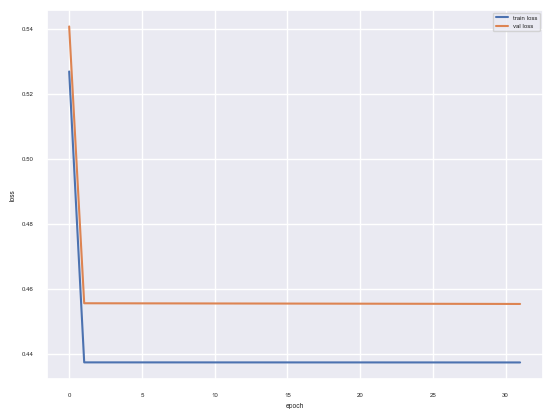

In [54]:
# plotting outcomes
epoch = torch.linspace(0,n_epochs+1,len(train_losses))
plt.plot(epoch, train_losses)
plt.plot(epoch, val_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train loss', 'val loss'],loc='upper right')
plt.show()

In [ ]:
# https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html
# checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']